# Project Notebooks
1.   Data Wrangling (current notebook)
2.   EDA
3.   Vector Modeling
4.   Graph Modeling



This notebook works to wrangle game, player, play, and tracking data provided by the NFL Big Data Bowl Kaggle Competition into suitable data structures to predict which reciever a quarterback will throw to during a specific play.

There are two ways to work with spatial data, such as on-field team performance data, that allow for various novel machine learning applications. Vector and Graph Representations.

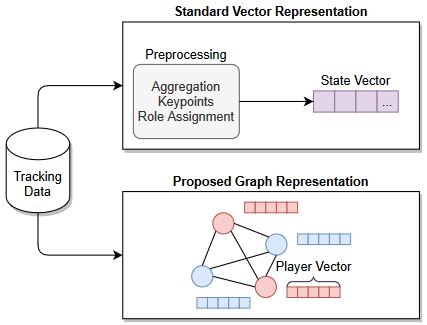

Xenopoulos and Silva (2021) Graph Neural Networks to Predict Sports Outcomes.

##Info on Vector Representations

Proposed Vector Representation Models


1.   Logistic Regression
2.   Random Forest
3.   Feed Forward Neural Net

These models work with vector data. This is typically what you think of with tabular data where each row corresponds to a sample and each column is a feature of that sample. In the case of spatial data, the order of inputs to the model must be given meaning and kept consistent in order to provide stable models. Features are typical derived from spatial distance calculations between player or objects on the field through aggregation or role assignments. Player specific features such as height, weight, etc are also usually included. Below is an example from Burke (2019) which the current project will use as a template to structure our vector representations. Potential Receivers on the field (to be predicted) will be ordered from shallowest on the field (closest to the line of scrimmage in the X direction).

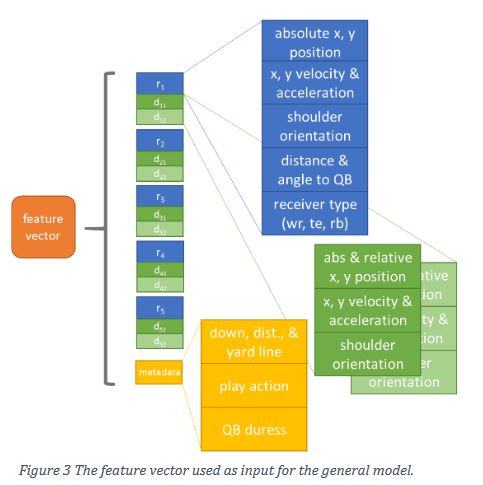 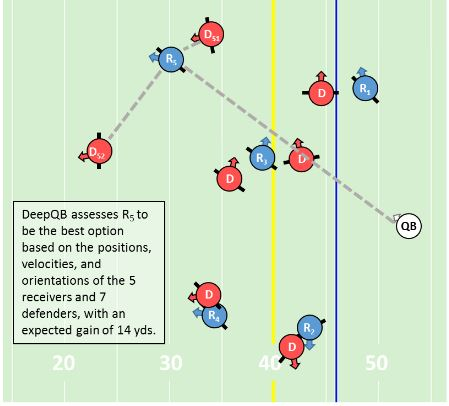

Burke 2019 DeepQb Deep Learning with Player Tracking to Quantify Quarterback Decision Making & Performance

##Info on Graph Representations

Graph Representation Models


1.   GCN
2.   GAT
3.   GCN LSTM

Graph data representations use relationships between entities to construct connections within the data set. Nodes are seen as entities (player, football, etc) and the edges between them can provide spatial or other contexts (distance between players, team relations, etc).

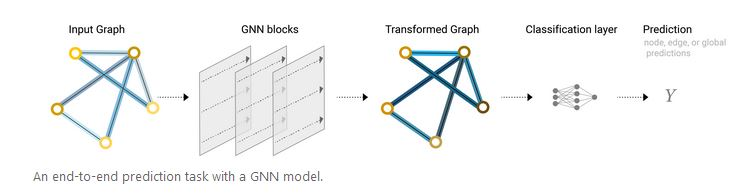

The inputs to the models are spatial characteristics of the players on the field and a set of engineered features based on distances between the players.

#Load Packages

In [ ]:
!pip install rpy2==3.5.1

# activate R magic
%reload_ext rpy2.ipython

In [ ]:
import sklearn
from sklearn.metrics.pairwise import euclidean_distances
import itertools
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist,squareform

In [ ]:
# Use R cell magic to import libraries for data manipulation
%%R
#Loading pre-installed libraries
library(tidyverse)
#library(cowplot)
library(repr)

#turning off warnings
options(warn=-1)

#Data Wrangling

##Fix known issues with data

Use R functions given by https://www.kaggle.com/code/tombliss/tutorial/notebook to correct tracking data then save as csv for further analysis in Python

In [ ]:
%%R
##Reading tracking data (needs to be done iteratively)

#weeks of NFL season
weeks <- seq(1, 17)

#blank dataframe to store tracking data
df_tracking <- data.frame()

#iterating through all weeks
for(w in weeks){

    #temperory dataframe used for reading week for given iteration
    df_tracking_temp <- read_csv(paste0("/content/drive/MyDrive/DS5500/Phase 2/week",w,".csv"),
                                col_types = cols())

    #storing temporary dataframe in full season dataframe
    df_tracking <- bind_rows(df_tracking_temp, df_tracking)

}

In [ ]:
%%R
#Standardizing tracking data so its always in direction of offense vs raw on-field coordinates.
df_tracking <- df_tracking %>%
                mutate(x = ifelse(playDirection == "left", 120-x, x),
                       y = ifelse(playDirection == "left", 160/3 - y, y))

In [ ]:
%%R
write.csv(df_tracking, "/content/drive/MyDrive/DS5500/Phase 2/fullTracking.csv", row.names=FALSE)

##Import

###Game Data

In [ ]:
# import raw game data csv
games = pd.read_csv('/content/drive/MyDrive/DS5500/Phase 2/games.csv')

# change date_time to binary "night" or "day" to indicate game time (factorized)
gameTime = pd.to_datetime(games.gameTimeEastern, format='%H:%M:%S')
newGameTime = []

for i in gameTime:
  if i >  pd.to_datetime('1900-01-01 19:00:00'):
    newGameTime.append("Night")
  else:
    newGameTime.append("Day")

games["Time"] = pd.Series(newGameTime).astype('category')
games.drop("gameTimeEastern", axis = 1, inplace = True)
games.head()

,gameId,gameDate,homeTeamAbbr,visitorTeamAbbr,week,Time
0,2018090600,09/06/2018,PHI,ATL,1,Night
1,2018090901,09/09/2018,CLE,PIT,1,Day
2,2018090902,09/09/2018,IND,CIN,1,Day
3,2018090903,09/09/2018,MIA,TEN,1,Day
4,2018090900,09/09/2018,BAL,BUF,1,Day


###Play Data

In [ ]:
plays = pd.read_csv('/content/drive/MyDrive/DS5500/Phase 2/plays.csv')
plays.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,offenseFormation,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,typeDropback,preSnapVisitorScore,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI
0,2018090600,75,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,ATL,play_type_pass,ATL,20,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,NaN,NaN,C,10,10,0.261827,False
1,2018090600,146,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,ATL,play_type_pass,PHI,39,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,13:10:00,49.0,NaN,NaN,I,0,0,-0.372360,False
2,2018090600,168,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,ATL,play_type_pass,PHI,39,SHOTGUN,"2 RB, 1 TE, 2 WR",6.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,13:05:00,49.0,NaN,NaN,I,0,0,-0.702779,False
3,2018090600,190,(13:01) (Shotgun) M.Ryan pass deep left to J.J...,1,3,10,ATL,play_type_pass,PHI,39,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,5.0,"4 DL, 1 LB, 6 DB",SCRAMBLE_ROLLOUT_LEFT,0.0,0.0,13:01:00,49.0,NaN,NaN,C,33,33,3.047530,False
4,2018090600,256,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,ATL,play_type_pass,PHI,1,SHOTGUN,"2 RB, 3 TE, 0 WR",8.0,6.0,"6 DL, 3 LB, 2 DB",TRADITIONAL,0.0,0.0,10:59:00,11.0,NaN,NaN,I,0,0,-0.842272,False


###Player Data

In [ ]:
players = pd.read_csv('/content/drive/MyDrive/DS5500/Phase 2/players.csv', usecols = ["nflId", "height", "weight"])
players.head()

,nflId,height,weight,birthDate,collegeName,position,displayName
0,2539334,72,190,1990-09-10,Washington,CB,Desmond Trufant
1,2539653,70,186,1988-11-01,Southeastern Louisiana,CB,Robert Alford
2,2543850,69,186,1991-12-18,Purdue,SS,Ricardo Allen
3,2555162,73,227,1994-11-04,Louisiana State,MLB,Deion Jones
4,2555255,75,232,1993-07-01,Minnesota,OLB,De'Vondre Campbell


###Tracking Data

In [ ]:
tracking = pd.read_csv('/content/drive/MyDrive/DS5500/Phase 2/fullTracking.csv').drop(['time', 'jerseyNumber', 'route'], axis = 1)

In [ ]:
# only subset to 'frames' corresponding to 0.5 sec before ball was thrown
# use 'football' display name to subset, then use 'event' to subset when the snap happened.
framesForGameState = tracking[["event", "displayName", "gameId", "frameId", "playId"]][(tracking['event'] == 'pass_forward') & (tracking['displayName'] == 'Football')]

# subtract 5 from frame number at appropriate event
framesForGameState["frameForGameState"] = framesForGameState.frameId - 5

# drop unnecessary columns and reset index for join later
framesForGameState.drop(["event", "displayName", "frameId"], axis = 1, inplace = True)
framesForGameState.set_index(['gameId', 'playId'], inplace = True)

GameState = framesForGameState.rename(columns = {'frameForGameState':'frameId'}).reset_index()

# join tracking data with GameState data
GameState = GameState.set_index(['gameId', 'playId', 'frameId']).join(tracking.set_index(['gameId', 'playId', 'frameId']))
GameState = GameState.reset_index().drop(['frameId', 'event', 'playDirection', 'displayName'], axis = 1)
GameState['nflId'] = pd.Series([int(i) if not np.isnan(i) else 0 for i in GameState.nflId])

# save new data frame as csv
GameState.to_csv('/content/drive/MyDrive/DS5500/Phase 2/GameState.csv')

# to save RAM
del tracking

In [ ]:
GameState = pd.read_csv('/content/drive/MyDrive/DS5500/Phase 2/GameState.csv')
print(GameState.shape)
GameState.head()

(260418, 12)


,gameId,playId,x,y,s,a,dis,o,dir,nflId,position,team
0,2018090600,75,23.74,26.853333,1.44,4.25,0.16,37.54,75.83,310,QB,away
1,2018090600,75,33.35,16.403333,3.72,3.45,0.36,246.53,292.49,79848,SS,home
2,2018090600,75,37.02,8.903333,6.21,3.04,0.64,279.62,275.90,2495454,WR,away
3,2018090600,75,33.09,33.343333,2.76,2.29,0.26,43.71,208.47,2495613,FS,home
4,2018090600,75,34.25,18.723333,5.79,2.84,0.57,265.07,262.10,2533040,WR,away


##Extract Reciever Data and Perform Feature Engineering

In [ ]:
# create play level feature names
recieverFeatures = ['nflId',
                    'x',
                    'y',
                    's',
                    'a',
                    'o',
                    'dir',
                    'dir_orient_diff',
                    'qb_dist',
                    'qb_orient_diff',
                    'qb_dir_diff',
                    'closest_dist',
                    'closest_s',
                    'closest_a',
                    'closest_orient_diff',
                    'closest_dir_diff',
                    'closest_3_avg_dist',
                    'closest_3_max_s',
                    'closest_3_max_a',
                    'position']

recieverFeatures = {'target_0' : dict.fromkeys(recieverFeatures),
                    'target_1' : dict.fromkeys(recieverFeatures),
                    'target_2' : dict.fromkeys(recieverFeatures),
                    'target_3' : dict.fromkeys(recieverFeatures),
                    'target_4' : dict.fromkeys(recieverFeatures),
                    'target_5' : dict.fromkeys(recieverFeatures)
                    }

qbFeatures = {'qb_features' : dict.fromkeys(['nflId', 'x', 'y', 's', 'a', 'orient', 'dir'])}

In [ ]:
playState = pd.DataFrame()

groups = GameState.groupby(['gameId', 'playId'])

for Id, g in groups:

  # get QB features
  if g.nflId[g.position == 'QB'].size != 1:
    continue

  tempQbFeatures = qbFeatures

  tempQbFeatures['qb_features']['nflId'] = int(g.nflId[g.position == 'QB'])
  tempQbFeatures['qb_features']['x'] = float(g.x[g.position == 'QB'])
  tempQbFeatures['qb_features']['y'] = float(g.y[g.position == 'QB'])
  tempQbFeatures['qb_features']['s'] = float(g.s[g.position == 'QB'])
  tempQbFeatures['qb_features']['a'] = float(g.a[g.position == 'QB'])
  tempQbFeatures['qb_features']['orient'] = float(g.o[g.position == 'QB'])
  tempQbFeatures['qb_features']['dir'] = float(g.dir[g.position == 'QB'])

  # get reciever features

  tempRecieverFeatures = recieverFeatures

  tempRecieverFeaturesKeys = list(tempRecieverFeatures.keys())

  if len(tempRecieverFeaturesKeys) < 1:
    continue

  # separate offense v defense
  groupOff = g[g.position.isin(['WR', 'RB', 'FB', 'TE'])].copy()
  groupDef = g[g.position.isin(['SS', 'FS', 'ILB', 'MLB', 'CB', 'LB'])].copy()

  # check if defensive tracking got dropped
  if groupDef.size < 1:
    continue

  # get nflIDs of groupOff targets in order of shallowest to deepest
  recievers = list(groupOff.nflId.iloc[groupOff.x.values.argsort()])

  # iterate through this list concatentating info about Def
  for i, recieverId in zip(range(len(recievers)), recievers):

    # add reciever data to appropriate spot in dictionary
    tempRecieverFeatures[tempRecieverFeaturesKeys[i]]['nflId'] = int(recieverId)
    tempRecieverFeatures[tempRecieverFeaturesKeys[i]]['position'] = list(g.position[g.nflId == recieverId])[0]
    tempRecieverFeatures[tempRecieverFeaturesKeys[i]]['x'] = float(g.x[g.nflId == recieverId])
    tempRecieverFeatures[tempRecieverFeaturesKeys[i]]['y'] = float(g.y[g.nflId == recieverId])
    tempRecieverFeatures[tempRecieverFeaturesKeys[i]]['s'] = float(g.s[g.nflId == recieverId])
    tempRecieverFeatures[tempRecieverFeaturesKeys[i]]['a'] = float(g.a[g.nflId == recieverId])
    tempRecieverFeatures[tempRecieverFeaturesKeys[i]]['o'] = float(g.o[g.nflId == recieverId])
    tempRecieverFeatures[tempRecieverFeaturesKeys[i]]['dir'] = float(g.dir[g.nflId == recieverId])
    tempRecieverFeatures[tempRecieverFeaturesKeys[i]]['dir_orient_diff'] = float(abs(g.dir[g.nflId == recieverId] - g.o[g.nflId == recieverId]))
    tempRecieverFeatures[tempRecieverFeaturesKeys[i]]['qb_dist'] = np.linalg.norm(np.array(g[['x', 'y']][g.position == 'QB']) - np.array(g[['x', 'y']][g.nflId == recieverId]))
    tempRecieverFeatures[tempRecieverFeaturesKeys[i]]['qb_orient_diff'] = float(g.o[g.position == 'QB']) - float(g.o[g.nflId == recieverId])
    tempRecieverFeatures[tempRecieverFeaturesKeys[i]]['qb_dir_diff'] = float(g.dir[g.position == 'QB']) - float(g.dir[g.nflId == recieverId])

    # get defense distances to the particular reciever
    groupDef['dist2rec'] = euclidean_distances(groupDef[['x', 'y']], g[['x', 'y']][g.nflId == recieverId])

    # stats for def closest to reciever
    tempRecieverFeatures[tempRecieverFeaturesKeys[i]]['closest_dist'] = float(min(groupDef.dist2rec))
    tempRecieverFeatures[tempRecieverFeaturesKeys[i]]['closest_s'] = float(groupDef.s.iloc[np.argmin(groupDef.dist2rec)])
    tempRecieverFeatures[tempRecieverFeaturesKeys[i]]['closest_a'] = float(groupDef.a.iloc[np.argmin(groupDef.dist2rec)])
    tempRecieverFeatures[tempRecieverFeaturesKeys[i]]['closest_orient_diff'] = float(groupDef.o.iloc[np.argmin(groupDef.dist2rec)] - g.o[g.nflId == recieverId])
    tempRecieverFeatures[tempRecieverFeaturesKeys[i]]['closest_dir_diff'] = float(groupDef.dir.iloc[np.argmin(groupDef.dist2rec)] - g.dir[g.nflId == recieverId])

    # stats for 3 closest defs to reciever
    three_closest = groupDef.iloc[groupDef.dist2rec.values.argsort()[:3]]
    tempRecieverFeatures[tempRecieverFeaturesKeys[i]]['closest_3_avg_dist'] = float(np.mean(three_closest.dist2rec))
    tempRecieverFeatures[tempRecieverFeaturesKeys[i]]['closest_3_max_s'] = float(max(three_closest.s))
    tempRecieverFeatures[tempRecieverFeaturesKeys[i]]['closest_3_max_a'] = float(max(three_closest.a))

  # concat both qb and reciever features into single dictionary
  tempPlayState = {**tempQbFeatures, **tempRecieverFeatures}

  # unravel tempPlayState into single row of pandas data frame
  tempPlayState = pd.DataFrame(pd.json_normalize(tempPlayState, sep = '_'))
  tempPlayState['gameId'], tempPlayState['playId'] = Id[0], Id[1]

  # add to ever growning full data frame
  playState = pd.concat([playState, tempPlayState], ignore_index = True)

playState.set_index(['gameId', 'playId'], inplace = True)

In [ ]:
# join game and play data (adds 'week' and 'game time' to plays df)
plays = games.set_index('gameId').join(plays.set_index('gameId')).reset_index()

# join framesForGameStates and play data (adds frameForGameState variable to plays)
plays = playState.join(plays.set_index(['gameId', 'playId']))

plays.head()

In [ ]:
# also add targeted reciever to make true label
targetedRecievers = pd.read_csv("/content/drive/MyDrive/DS5500/Phase 2/targetedReceiver.xls")

# join targets recievers and play data (adds ground truth reciever to plays)
plays = targetedRecievers.set_index(['gameId', 'playId']).join(plays).reset_index()

plays.head()

##Fix truth label target IDs

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/DS5500/Phase 2/fullPassPlayStates.csv")

targetLabels = ['target_0_nflId', 'target_1_nflId','target_2_nflId','target_3_nflId', 'target_4_nflId', 'target_5_nflId']

trueTargetLabels = []
for rows in range(len(data)):
  row = data.iloc[rows,]

  if row.targetNflId in list(row[targetLabels]):
    temp = list(row.targetNflId == row[targetLabels]).index(True)
  else:
    temp = None

  trueTargetLabels = trueTargetLabels + [temp]

data['trueTargetLabels'] = pd.array(trueTargetLabels, dtype=pd.Int64Dtype())

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/DS5500/Phase 2/fullPassPlayStates.csv")
data['trueTargetLabels'] = data.trueTargetLabels.astype(pd.Int64Dtype())
data['targetNflId'] = data.targetNflId.astype(pd.Int64Dtype())
data.head()

,gameId,playId,targetNflId,qb_features_nflId,qb_features_x,qb_features_y,qb_features_s,qb_features_a,qb_features_orient,qb_features_dir,target_0_nflId,target_0_x,target_0_y,target_0_s,target_0_a,target_0_o,target_0_dir,target_0_dir_orient_diff,target_0_qb_dist,target_0_qb_orient_diff,target_0_qb_dir_diff,target_0_closest_dist,target_0_closest_s,target_0_closest_a,target_0_closest_orient_diff,target_0_closest_dir_diff,target_0_closest_3_avg_dist,target_0_closest_3_max_s,target_0_closest_3_max_a,target_0_position,target_1_nflId,target_1_x,target_1_y,target_1_s,target_1_a,target_1_o,target_1_dir,target_1_dir_orient_diff,target_1_qb_dist,target_1_qb_orient_diff,target_1_qb_dir_diff,target_1_closest_dist,target_1_closest_s,target_1_closest_a,target_1_closest_orient_diff,target_1_closest_dir_diff,target_1_closest_3_avg_dist,target_1_closest_3_max_s,target_1_closest_3_max_a,target_1_position,target_2_nflId,target_2_x,target_2_y,target_2_s,target_2_a,target_2_o,target_2_dir,target_2_dir_orient_diff,target_2_qb_dist,target_2_qb_orient_diff,target_2_qb_dir_diff,target_2_closest_dist,target_2_closest_s,target_2_closest_a,target_2_closest_orient_diff,target_2_closest_dir_diff,target_2_closest_3_avg_dist,target_2_closest_3_max_s,target_2_closest_3_max_a,target_2_position,target_3_nflId,target_3_x,target_3_y,target_3_s,target_3_a,target_3_o,target_3_dir,target_3_dir_orient_diff,target_3_qb_dist,target_3_qb_orient_diff,target_3_qb_dir_diff,target_3_closest_dist,target_3_closest_s,target_3_closest_a,target_3_closest_orient_diff,target_3_closest_dir_diff,target_3_closest_3_avg_dist,target_3_closest_3_max_s,target_3_closest_3_max_a,target_3_position,target_4_nflId,target_4_x,target_4_y,target_4_s,target_4_a,target_4_o,target_4_dir,target_4_dir_orient_diff,target_4_qb_dist,target_4_qb_orient_diff,target_4_qb_dir_diff,target_4_closest_dist,target_4_closest_s,target_4_closest_a,target_4_closest_orient_diff,target_4_closest_dir_diff,target_4_closest_3_avg_dist,target_4_closest_3_max_s,target_4_closest_3_max_a,target_4_position,target_5_nflId,target_5_x,target_5_y,target_5_s,target_5_a,target_5_o,target_5_dir,target_5_dir_orient_diff,target_5_qb_dist,target_5_qb_orient_diff,target_5_qb_dir_diff,target_5_closest_dist,target_5_closest_s,target_5_closest_a,target_5_closest_orient_diff,target_5_closest_dir_diff,target_5_closest_3_avg_dist,target_5_closest_3_max_s,target_5_closest_3_max_a,target_5_position,week,Time,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,offenseFormation,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,typeDropback,preSnapVisitorScore,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI,trueTargetLabels
0,2018090600,75,2495454,310.0,23.74,26.853333,1.44,4.25,37.54,75.83,2543583.0,24.92,27.383333,3.70,3.87,294.66,296.70,2.04,1.293561,-257.12,-220.87,9.935819,3.29,2.98,-233.58,25.76,10.179599,3.29,3.44,RB,2559033.0,28.68,32.193333,6.05,0.72,231.62,215.54,16.08,7.274558,-194.08,-139.71,4.557477,2.76,2.29,-187.91,-7.07,7.688528,2.76,3.44,FB,2555415.0,33.85,31.793333,5.43,1.41,267.41,270.55,3.14,11.252364,-229.87,-194.72,1.726297,2.76,2.29,-223.70,-62.08,3.809690,2.76,3.44,TE,2533040.0,34.25,18.723333,5.79,2.84,265.07,262.10,2.97,13.287475,-227.53,-186.27,2.488453,3.72,3.45,-18.54,30.39,4.861545,3.72,3.45,WR,2495454.0,37.02,8.903333,6.21,3.04,279.62,275.90,3.72,22.328477,-242.08,-200.07,3.931272,5.34,0.76,-89.62,4.95,8.427943,5.34,3.45,WR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Night,(15:00) M.Ryan pass short right to J.Jones pus...,1.0,1.0,15.0,ATL,play_type_pass,ATL,20.0,I_FORM,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0.0,0.0,15:00:00,90.0,NaN,NaN,C,10.0,10.0,0.261827,False,4
1,2018090600,146,2560854,310.0,66.48,23.773333,1.77,3.62,30.44,84.49,2543583.0,64.21,25.503333,2.75,2.27,246.15,181.30,64.85,2.854085,-215.71,-96.81,9.952336,